In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
from os import listdir
import pathlib
from random import randint
import numpy as np
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import tensorflow_addons as tfa
from keras.utils import load_img,img_to_array
from keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import MaxPooling2D,Dropout,Dense,Input,Conv2D,Flatten,Conv2DTranspose
from keras.layers import GlobalAveragePooling2D,MaxPool2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

In [8]:
folder = r'D:\5 class alziemers\Alzheimers-ADNI\train'
folder_path = pathlib.Path(folder)

In [9]:
for file in listdir(folder):
    print(file)

Final AD JPEG
Final CN JPEG
Final EMCI JPEG
Final LMCI JPEG
Final MCI JPEG


In [10]:
# counting the number of images in each category
for file in listdir(folder):
    i =0
    for image in listdir(folder + '/'+file):
        i = i +1
    print(file , i)

Final AD JPEG 145
Final CN JPEG 493
Final EMCI JPEG 204
Final LMCI JPEG 61
Final MCI JPEG 198


In [6]:
# Creating the image datagenerator to have more samples
IMG_SIZE = 128
DIM = (IMG_SIZE, IMG_SIZE)

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

In [14]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from PIL import Image

# Define the root directory
root_directory = r'D:\5 class alziemers\Alzheimers-ADNI\train'

# Define the class labels and their respective folder names
class_labels = ['Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG']

# Define the augmentation settings
datagen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.5, 1.5)
)

# Define the target size of the images
SIZE = 224

# Iterate over each class label
for label in class_labels:
    # Define the directory path for the current class label
    class_directory = os.path.join(root_directory, label)

    # Define the output directory for augmented images
    augmented_directory = os.path.join(root_directory, 'Augmented', label)
    os.makedirs(augmented_directory, exist_ok=True)

    # Collect the list of image files in the class directory
    image_files = [
        os.path.join(class_directory, file)
        for file in os.listdir(class_directory)
        if file.lower().endswith('.jpg')
    ]

    # Load and augment the images
    dataset = []
    for image_file in image_files:
        image = Image.open(image_file)
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))

    x = np.array(dataset)

    # Reshape the input to have a rank of 4
    x = np.expand_dims(x, axis=3)

    # Generate augmented images and save them
    i = 0
    for batch in datagen.flow(x, batch_size=16, save_to_dir=augmented_directory, save_prefix='augmented', save_format='jpg'):
        i += 1
        if i > 50:
            break

    print(f"Augmentation completed for {label}")

print("Data augmentation completed.")


Augmentation completed for Final AD JPEG
Augmentation completed for Final CN JPEG
Augmentation completed for Final EMCI JPEG
Augmentation completed for Final LMCI JPEG
Augmentation completed for Final MCI JPEG
Data augmentation completed.


In [15]:
# Count the total number of augmented images and images for each class label
total_augmented_images = 0
class_counts = {}

# Iterate over each class label
for label in class_labels:
    augmented_folder_path = os.path.join(root_directory, 'Augmented', label)
    #print(augmented_folder_path)
    num_images = len(os.listdir(augmented_folder_path))
    total_augmented_images += num_images
    class_counts[label] = num_images

# Print the total number of augmented images and images for each class label
print(f"Total Augmented Images: {total_augmented_images}")
for label, count in class_counts.items():
    print(f"{label}: {count}")


D:\5 class alziemers\Alzheimers-ADNI\train\Augmented\Final AD JPEG
D:\5 class alziemers\Alzheimers-ADNI\train\Augmented\Final CN JPEG
D:\5 class alziemers\Alzheimers-ADNI\train\Augmented\Final EMCI JPEG
D:\5 class alziemers\Alzheimers-ADNI\train\Augmented\Final LMCI JPEG
D:\5 class alziemers\Alzheimers-ADNI\train\Augmented\Final MCI JPEG
Total Augmented Images: 3924
Final AD JPEG: 741
Final CN JPEG: 813
Final EMCI JPEG: 804
Final LMCI JPEG: 780
Final MCI JPEG: 786


In [17]:
folder=r'D:\5 class alziemers\Alzheimers-ADNI\train\Augmented'
train_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, 
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)
train_data_gen = train_generator.flow_from_directory(directory=folder, target_size=DIM, batch_size=6500, shuffle=False)

Found 3924 images belonging to 5 classes.


In [19]:
import cv2
import os
import glob
import numpy as np

# set paths to the directory containing the images
train_dir = r'D:\5 class alziemers\Alzheimers-ADNI\train\Augmented'
test_dir = r'D:\5 class alziemers\Alzheimers-ADNI\test'

# define function to read and preprocess images from directory
def read_images_from_dir(directory):
    images = []
    labels = []
    for class_label in os.listdir(directory):
        class_path = os.path.join(directory, class_label)
        if os.path.isdir(class_path):
            for file_name in glob.glob(os.path.join(class_path, '*.jpg')):
                image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, (256, 256)) # resize to common size
                images.append(image)
                labels.append(class_label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# read and preprocess images and labels from train, test, and validation directories
X_train, y_train = read_images_from_dir(train_dir)
X_test, y_test = read_images_from_dir(test_dir)

# print shapes of the loaded images and labels
print("Train images shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test images shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Train images shape: (3924, 256, 256)
Train labels shape: (3924,)
Test images shape: (195, 256, 256)
Test labels shape: (195,)


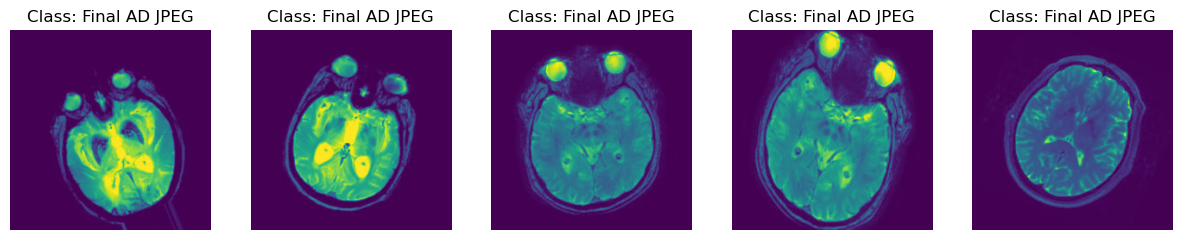

In [21]:
import numpy as np
import matplotlib.pyplot as plt
num_samples = 5  # number of samples to display
random_indices = np.random.randint(0, len(X_test), num_samples)
plt.figure(figsize=(15,5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(X_train[idx])
    plt.title('Class: {}'.format(y_train[idx]))
    plt.axis('off')
plt.show()

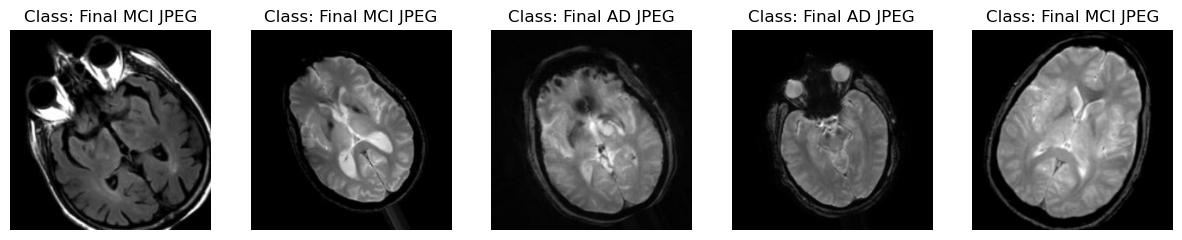

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Display some sample grayscale images with their class labels
num_samples = 5  # number of samples to display
random_indices = np.random.randint(0, len(X_train), num_samples)
plt.figure(figsize=(15,5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title('Class: {}'.format(y_train[idx]))
    plt.axis('off')
plt.show()

In [49]:
test_folder=r'D:\5 class alziemers\Alzheimers-ADNI\test'
test_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, 
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)
test_data_gen = train_generator.flow_from_directory(directory=test_folder, target_size=DIM, batch_size=6500, shuffle=False)

Found 195 images belonging to 5 classes.


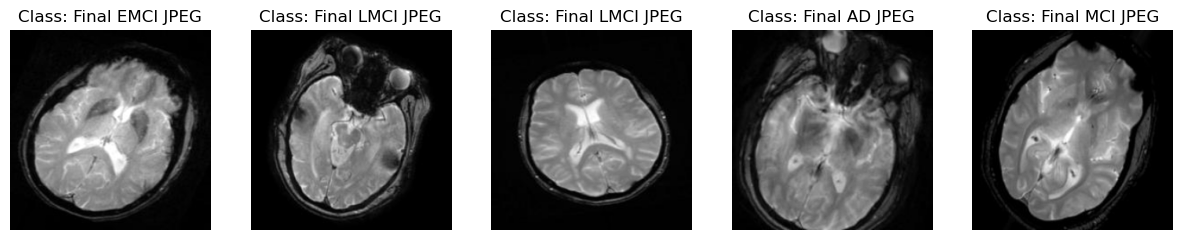

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Display some sample grayscale images with their class labels
num_samples = 5  # number of samples to display
random_indices = np.random.randint(0, len(X_train), num_samples)
plt.figure(figsize=(15,5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title('Class: {}'.format(y_train[idx]))
    plt.axis('off')
plt.show()

In [141]:
train_data, train_labels = train_data_gen.next()

In [50]:
test_data, test_labels = test_data_gen.next()

In [90]:
train_data.shape, train_labels.shape

((3924, 128, 128, 3), (3924, 5))

In [29]:
test_data.shape, test_labels.shape

((195, 128, 128, 3), (195, 5))

In [35]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

print(train_data.shape, train_labels.shape)

(4065, 49152) (4065, 5)


In [21]:
"""Did not ran
sm = SMOTE(random_state=42)

test_data, test_labels = sm.fit_resample(test_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), test_labels)

print(test_data.shape, test_labels.shape)
"""

(435, 49152) (435, 5)


In [37]:
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(4065, 128, 128, 3) (4065, 5)


In [38]:
test_data = test_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(test_data.shape, test_labels.shape)

(195, 128, 128, 3) (195, 5)


In [51]:
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
#print(val_data.shape, val_labels.shape)

(3252, 128, 128, 3) (3252, 5)
(195, 128, 128, 3) (195, 5)


In [189]:
train_data, test_data, train_labels,test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=30)
print("Train size",train_data.shape, train_labels.shape)
print("test size",test_data.shape, test_labels.shape)


Train size (12, 128, 128, 3) (12, 5)
test size (4, 128, 128, 3) (4, 5)


In [40]:
# Defining convolutional blocks
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [41]:
# defining dense blocks
def dense_block(units, dropout_rate, act='relu'):
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [42]:
IMAGE_SIZE = [128,128]
act = 'relu'

In [44]:
model = Sequential([
    Input(shape=(*IMAGE_SIZE, 3)),
    Conv2D(32, 3, activation='relu', padding='same'),
    Conv2D(32, 3, activation='relu', padding='same'),
    MaxPool2D(),
    conv_block(64),
    conv_block(128),
    conv_block(256),
    MaxPool2D(),
    Dropout(0.2),
    conv_block(512),
    Dropout(0.25),
    Flatten(),
    dense_block(1024, 0.3),
    dense_block(512, 0.3),
    Dense(5, activation='softmax')
], name="cnn_model")


In [45]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=5)]

model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 sequential_7 (Sequential)   (None, 32, 32, 64)        55680     
                                                                 
 sequential_8 (Sequential)   (None, 16, 16, 128)       221952    
                                                                 
 sequential_9 (Sequential)   (None, 8, 8, 256)         886272    
                                                         

In [31]:
CALLBACKS = [
    EarlyStopping(monitor='accuracy', min_delta=0.01, patience=5, mode='max')
]

In [52]:
EPOCHS = 40

history = model.fit(train_data, train_labels, validation_data=(test_data, test_labels), epochs=EPOCHS)

Epoch 1/40
102/102 [==============================] - 190s 2s/step - loss: 2.1662 - acc: 0.2180 - auc: 0.5137 - f1_score: 0.2179 - val_loss: 7.4944 - val_acc: 0.1846 - val_auc: 0.4889 - val_f1_score: 0.0623
Epoch 2/40
102/102 [==============================] - 3793s 38s/step - loss: 1.8619 - acc: 0.2214 - auc: 0.5312 - f1_score: 0.2211 - val_loss: 6.5312 - val_acc: 0.1282 - val_auc: 0.4330 - val_f1_score: 0.0465
Epoch 3/40
102/102 [==============================] - 137s 1s/step - loss: 1.8195 - acc: 0.2297 - auc: 0.5280 - f1_score: 0.2295 - val_loss: 4.9627 - val_acc: 0.1487 - val_auc: 0.5574 - val_f1_score: 0.0725
Epoch 4/40
102/102 [==============================] - 143s 1s/step - loss: 1.8323 - acc: 0.2245 - auc: 0.5239 - f1_score: 0.2243 - val_loss: 3.5879 - val_acc: 0.1744 - val_auc: 0.4541 - val_f1_score: 0.0621
Epoch 5/40
102/102 [==============================] - 130s 1s/step - loss: 1.7793 - acc: 0.2223 - auc: 0.5248 - f1_score: 0.2219 - val_loss: 1.6725 - val_acc: 0.3179 - va

In [190]:
test_scores = model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

1/1 [==============================] - 0s 113ms/step - loss: 0.8675 - acc: 0.7500 - auc: 0.9375 - f1_score: 0.3600
Testing Accuracy: 75.00%


In [35]:
model.save("model2_alziemers.h5")
model_path = "model2_alziemers.h5"

In [50]:
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
import numpy
import cv2
from tkinter import messagebox


#load the trained model to classify the images
from keras.models import load_model
model = load_model('model1_alziemers10epoch.h5')
#dictionary to label all the CIFAR-10 dataset classes.
class_names = { 
    0:'Final AD JPEG',
    1:'Final CN JPEG',
    2:'Final EMCI JPEG',
    3:'Final LMCI JPEG',
    4:'Final MCI JPEG',
}
#initialise GUI
top=tk.Tk()
top.geometry('800x600')
top.title('Image Classification Alzheimers Disease')
top.configure(background='#CDCDCD')
label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)

def classify(file_path):
    image = Image.open(file_path)
    img_array = np.array(image)
    img_resized = cv2.resize(img_array, (128, 128))
    # Convert grayscale image to RGB
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
    # Add an extra dimension to the array to create a batch of size 1
    img_batch = np.expand_dims(img_rgb, axis=0)
    # Normalize the pixel values
    img_batch = img_batch / 255.0
    pred_probs = model.predict(img_batch)[0]
    pred_class = np.argmax(pred_probs)
    label = class_names[pred_class]
    messagebox.showinfo("Prediction", f"The image is {label}.")


def show_classify_button(file_path):
    classify_b=Button(top,text="Classify Image",
   command=lambda: classify(file_path),padx=10,pady=5)
    classify_b.configure(background='#364156', foreground='white',
font=('arial',10,'bold'))
    classify_b.place(relx=0.79,rely=0.46)
def upload_image():
    try:
        file_path=filedialog.askopenfilename()
        uploaded=Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.25),(top.winfo_height()/2.25)))
        im=ImageTk.PhotoImage(uploaded)
        sign_image.configure(image=im)
        sign_image.image=im
        label.configure(text='')
        show_classify_button(file_path)
    except:
        pass
upload=Button(top,text="Upload an image",command=upload_image,
  padx=10,pady=5)
upload.configure(background='#364156', foreground='white',
    font=('arial',10,'bold'))
upload.pack(side=BOTTOM,pady=50)
sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
heading = Label(top, text="Image Classification Alzheimers Disease ",pady=20, font=('arial',20,'bold'))
heading.configure(background='#CDCDCD',foreground='#364156')
heading.pack()
top.mainloop()


In [29]:
import cv2

# set the path to the image file
image_path = r"D:\Alzheimers-ADNI\train\Final AD JPEG\ADNI_002_S_4229_MR_Axial_T2_STAR__br_raw_20170921122709574_22_S610930_I906802.jpg"

# load the image using OpenCV
image = cv2.imread(image_path)

# check the shape of the image
print(image.shape)


(150, 150, 3)


In [33]:
import cv2
import numpy as np

# Load the image

img = cv2.imread(r"D:\Alzheimers-ADNI\train\Final AD JPEG\ADNI_002_S_4229_MR_Axial_T2_STAR__br_raw_20170921122709574_22_S610930_I906802.jpg"
)

# Resize the image to (128, 128) and convert to NumPy array
img_resized = cv2.resize(img, (128, 128))
img_array = np.array(img_resized)

# Add an extra dimension to the array to create a batch of size 1
img_batch = np.expand_dims(img_array, axis=0)

# Normalize the pixel values
img_batch = img_batch / 255.0

# The shape of the image batch is now (1, 128, 128, 3)
print(img_batch.shape)


(1, 128, 128, 3)


In [48]:
from flask import Flask, render_template, request, jsonify
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

app = Flask(__name__)

model = tf.keras.models.load_model("model1_alziemers10epoch.h5")

class_names = { 
    0:'Final AD JPEG',
    1:'Final CN JPEG',
    2:'Final EMCI JPEG',
    3:'Final LMCI JPEG',
    4:'Final MCI JPEG',
}

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    if request.method == 'POST':
        img_file = request.files['image']
        img = image.load_img(img_file, target_size=(224, 224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
        prediction = model.predict(img)
        pred_class = np.argmax(prediction)
        label = class_names[pred_class]
        return jsonify({'result.html': label})

if __name__ == '__main__':
    try:
        app.run(debug=True)
    except Exception as e:
        import traceback
        print(traceback.format_exc())



 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

In [46]:
pip install flask



     ---------------------------------------- 96.9/96.9 kB 1.4 MB/s eta 0:00:00
  Using cached itsdangerous-2.1.2-py3-none-any.whl (15 kB)
     -------------------------------------- 242.3/242.3 kB 2.5 MB/s eta 0:00:00
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 2.2.2
    Uninstalling Werkzeug-2.2.2:
      Successfully uninstalled Werkzeug-2.2.2
  Attempting uninstall: click
    Found existing installation: click 8.0.4
    Uninstalling click-8.0.4:
      Successfully uninstalled click-8.0.4
  Attempting uninstall: blinker
    Found existing installation: blinker 1.4
    Uninstalling blinker-1.4:
      Successfully uninstalled blinker-1.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pathlib
from beecolpy import abc # import ABC from bee_colony module

# define the search space for ABC
search_space = {'learning_rate': {'type': 'float', 'min': 0.0001, 'max': 0.1},
                'dropout_rate': {'type': 'float', 'min': 0.2, 'max': 0.5},
                'batch_size': {'type': 'int', 'min': 32, 'max': 128},
                'num_filters': {'type': 'int', 'min': 16, 'max': 64}}


boundaries = [[search_space[param]['min'], search_space[param]['max']] for param in search_space]

# define the custom CNN architecture
def build_model(input_shape=(128, 128, 3), learning_rate=0.001, dropout_rate=0.3):
    model = keras.Sequential([
        keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=input_shape),
        keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
        keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
        keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
        keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(units=512, activation='relu'),
        keras.layers.Dropout(rate=dropout_rate),
        keras.layers.Dense(units=256, activation='relu'),
        keras.layers.Dropout(rate=dropout_rate),
        keras.layers.Dense(units=4, activation='softmax')
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])    
    return model
# set the data path
data_path = r'C:\Users\DELL\Downloads\alz 5 class\Alzheimers-ADNI'

# set the image size and batch size
image_size = (128, 128)
batch_size = 32

# define the image data generator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# load the training and validation data
train_data = train_datagen.flow_from_directory(directory=pathlib.Path(data_path) / 'train',
                                               target_size=image_size,
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=True,
                                               subset='training')

val_data = train_datagen.flow_from_directory(directory=pathlib.Path(data_path) / 'train',
                                             target_size=image_size,
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             shuffle=True,
                                             subset='validation')
epochs=30
# define the fitness function for the ABC algorithm
def fitness_function(x):
    # convert the ABC search space to model hyperparameters
    params = {'learning_rate': x[0],
              'dropout_rate': x[1],
              'batch_size': int(x[2]),
              'num_filters':int(x[3])
             }
    
    # build the model with the hyperparameters
    model = build_model(learning_rate=params['learning_rate'], dropout_rate=params['dropout_rate'])
    
    # train the model
    train_data_full = train_datagen.flow_from_directory(directory=pathlib.Path(data_path) / 'train',
                                                     target_size=image_size,
                                                     class_mode='categorical',
                                                     batch_size=int(params['batch_size']), # convert to integer
                                                     shuffle=True)

    model.fit(train_data_full,
              epochs=epochs,
              validation_data=val_data,
              callbacks=[keras.callbacks.EarlyStopping(patience=3)])
    print('learning rate',params['learning_rate'])
    print('dropout rate',params['dropout_rate'])
    # evaluate the model on the test set
    test_data = test_datagen.flow_from_directory(directory=pathlib.Path(data_path) / 'test',
                                                 target_size=image_size,
                                                 class_mode='categorical',
                                                 batch_size=int(params['batch_size']),
                                                 shuffle=False)

    # evaluate the final model on the test set
    loss, accuracy = model.evaluate(test_data)

    print('Test loss:', loss)
    print('Test accuracy:', accuracy)
    
    # return the negative of accuracy as the fitness value for ABC
    return -accuracy

# Define the ABC optimization algorithm
abc_optimizer = abc(fitness_function,boundaries )

# Run the ABC optimization algorithm
best_params, best_fitness = abc_optimizer.optimize()

# Print the best parameters and fitness
print("Best Parameters:", best_params)
print("Best Fitness:", best_fitness)


# Build the final model using the best hyperparameters found by ABC
model = build_model()
optimizer = keras.optimizers.Adam
optimizer.learning_rate = best_params['learning_rate']
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the final model on the full training set
train_data_full = train_datagen.flow_from_directory(directory=pathlib.Path(data_path) / 'train',
                                                    target_size=image_size,
                                                    class_mode='categorical',
                                                    batch_size=int(best_params['batch_size']),
                                                    shuffle=True)

model.fit(train_data_full,
          epochs=epochs,
          callbacks=[keras.callbacks.EarlyStopping(patience=3)])


# Evaluate the final model on the test set
test_data = test_datagen.flow_from_directory(directory=pathlib.Path(data_path) / 'test',
                                             target_size=image_size,
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             shuffle=False)

loss, accuracy = model.evaluate(test_data)

print('Test loss:', loss)
print('Test accuracy:', accuracy)